# Required libraries

In [1]:
#!pip install biopython

In [2]:
import numpy as np
import graphviz
import random as rd
import copy
from Bio.Seq import Seq
from Bio import AlignIO
import time
import matplotlib.pyplot as plt

# Small parsimony

## Useful functions

In [3]:
def example_w(x,y):
    """
    Example pairwise distance w

    Args:
     x: character or gap
     y: character or gap

    Returns: integer distance
    """
    if x==y: return 0
    elif x=='-' or y=='-': return 2 # corresponding to linear gap cost g(k)=2k
    else: return 3 # uniform mismatch cost

## Tree construction by UPGMA

In [4]:
def upgma(matrix):
    """
    UPGMA

    Args:
        matrix: distance matrix
    Returns:
        binary upgma tree
    """
    matrix = np.array(matrix)
    card = np.ones(len(matrix))
    T = tuple(range(len(matrix)))
    while len(T) > 2:
        mask = ~np.eye(matrix.shape[0], dtype=bool)
        masked_matrix = np.where(mask, matrix, np.inf)
        i, j = np.unravel_index(np.argmin(masked_matrix), matrix.shape) # get the minimal distance
        Ci, Cj = T[i], T[j]
        cardNew = card[i] + card[j]
        T = tuple(element for element in T if element not in (Ci, Cj))
        T = T + ((Ci, Cj),)
        new_row = [(matrix[i, l]*card[i] + matrix[j, l]*card[j])/cardNew for l in range(len(matrix)) if l not in (i, j)]
        matrix = np.delete(np.delete(matrix, max(i, j), axis=0), min(i, j), axis=0) # modify the distance matrix
        matrix = np.delete(np.delete(matrix, max(i, j), axis=1), min(i, j), axis=1)
        matrix = np.vstack([matrix, new_row])
        new_row.append(0)
        matrix = np.column_stack([matrix, new_row])
        card = np.delete(np.delete(card, j), i) # update the cardinalities
        card = np.append(card, cardNew)
    return T

## Mulitple Sequence Alignment

In [5]:
def profile_alignment(A, B, w):
    """
    Needleman-Wunsch profile alignment

    Args:
        A: multiple sequence alignment
        B: multiple sequence alignment
        w: cost function (over alphabet and '-')
    Returns:
        Multiple alignment with minimum profile alignment cost
    """
    Kprime = len(A)
    Ksecond = len(B)
    na = len(A[0])
    nb = len(B[0])

    D = np.zeros((na+1,nb+1), dtype='int') # initialize the matrix as in the NW porcess
    D[0,0] = 0
    for i in range(1, na+1):
        D[i,0] = D[i-1,0] + np.sum([w(A[k][i-1], '-') for k in range(Kprime) for l in range(Ksecond)]) # pairwise sum cost
    for j in range(1, nb+1):
        D[0,j] = D[0,j-1] + np.sum([w('-', B[l][j-1]) for k in range(Kprime) for l in range(Ksecond)]) # pairwise sum cost

    for i in range(1,na+1): # fill the matrix as in the NW process
        for j in range(1,nb+1):
            D[i,j] = min(D[i-1,j-1] + np.sum([w(A[k][i-1], B[l][j-1]) for k in range(Kprime) for l in range(Ksecond)]), # pairwise sum cost
                         D[i-1,j] + np.sum([w(A[k][i-1], '-') for k in range(Kprime) for l in range(Ksecond)]), # pairwise sum cost
                         D[i,j-1] + np.sum([w('-', B[l][j-1]) for k in range(Kprime) for l in range(Ksecond)])) # pairwise sum cost
    AA = ["" for a in A]
    BB = ["" for b in B]
    i = na
    j = nb
    while i>0 or j>0: # backtrack like in the NW porcess
        if i>0 and j>0 and D[i,j] == D[i-1,j-1]+np.sum([w(A[k][i-1],B[l][j-1]) for k in range(Kprime) for l in range(Ksecond)]):
            for k in range(Kprime): # extend the strings of all the sequences
                AA[k] = A[k][i-1] + AA[k]
            for l in range(Ksecond): # extend the strings of all the sequences
                BB[l] = B[l][j-1] + BB[l]
            i -= 1
            j -= 1
        elif i>0 and D[i,j] == D[i-1,j]+np.sum([w(A[k][i-1],'-') for k in range(Kprime) for l in range(Ksecond)]):
            for k in range(Kprime): # extend the strings of all the sequences
                AA[k] = A[k][i-1] + AA[k]
            for l in range(Ksecond): # extend the strings of all the sequences
                BB[l] = '-' + BB[l]
            i -= 1
        else:
            for k in range(Kprime): # extend the strings of all the sequences
                AA[k] = '-' + AA[k]
            for l in range(Ksecond): # extend the strings of all the sequences
                BB[l] = B[l][j-1] + BB[l]
            j -= 1

    AB = AA + BB

    return AB, D[na, nb]


def distance_matrix(sequences,w):
    """
    Compute pairwise alignment distances

    Args:
        sequences: list of input sequences
        w: distance function
    Returns: matrix of all pairwise alignment distances
    """
    n = len(sequences)
    pairwise_D = np.zeros((n, n))

    for k in range(n):
        a = sequences[k]
        for l in range(k+1, n):
            b = sequences[l]
            D = np.zeros((len(a)+1,len(b)+1), dtype='int') # NW algorithm

            D[0,0] = 0
            for i in range(1,len(a)+1):
                D[i,0] = D[i-1,0] + w(a[i-1],'-')
            for j in range(1,len(b)+1):
                D[0,j] = D[0,j-1] + w('-',b[j-1])

            for i in range(1,len(a)+1):
                for j in range(1,len(b)+1):
                    D[i,j] = min(D[i-1,j-1]+w(a[i-1],b[j-1]), D[i-1,j]+w(a[i-1],'-'), D[i,j-1]+w('-',b[j-1]))

            pairwise_D[k, l] = D[len(a), len(b)]
            pairwise_D[l, k] = D[len(a), len(b)]

    return pairwise_D


def guide_tree(sequences, w):
    """
    Compute guide tree

    Args:
        sequences: list of input sequences
        w: distance function
    Returns: guide tree
    """
    matrix = distance_matrix(sequences, w)
    return upgma(matrix)


def construct_MSA(tree, seqs, cost):
    if isinstance(tree[0], int):
        A = [seqs[tree[0]]] # construct a set of 1 sequence
    else:
        A, _ = construct_MSA(tree[0], seqs, cost)
    if isinstance(tree[1], int):
        B = [seqs[tree[1]]] # construct a set of 1 sequence
    else:
        B, _ = construct_MSA(tree[1], seqs, cost)
    return profile_alignment(A, B, cost)


def progressive_alignment(sequences, w):
    """
    Progressive multiple alignment

    Args:
        sequences: list of sequences
        w: cost function
    Returns:
        MSA constructed by progressive alignment algorithm
    """
    gt = guide_tree(sequences,w) # construct guide tree
    AB, score = construct_MSA(gt, sequences, w) # follow the guide tree and recursively construct larger and larger MSA
    return np.array(AB), score

## Small parsimony

In [6]:
def column_parsimony(tree, char_column):
    if not isinstance(tree[0], int):
        column_parsimony(tree[0], char_column)
    if not isinstance(tree[1], int):
        column_parsimony(tree[1], char_column)
    c0 = char_column[tree[0]].keys()
    c1 = char_column[tree[1]].keys()
    characters = set(list(c0)+list(c1))
    for c in characters:
        char_column[tree] = {}
        min0 = np.inf
        for k0 in c0:
            val = char_column[tree[0]][k0] + 1*(k0!=c)
            if val < min0:
                min0 = val
        min1 = np.inf
        for k1 in c1:
            val = char_column[tree[1]][k1] + 1*(k1!=c)
            if val < min1:
                min1 = val
        char_column[tree][c] = min0 + min1


def fill_seq(char_columns, ancestral_seq, tree, n):
    ancestral_seq.append("")
    for i in range(n):
        ancestral_seq[-1] += min(char_columns[i][tree], key=lambda c: char_columns[i][tree][c])
    if not isinstance(tree, int):
        fill_seq(char_columns, ancestral_seq, tree[0], n)
        fill_seq(char_columns, ancestral_seq, tree[1], n)


def small_parsimony(msa, tree):
    """
    Small parsimony

    Args:
        msa: multiple sequence alignment
        tree: tree over sequences / msa rows
    Returns:
        parsimony score, list of all ancestral sequences in pre-order of tree nodes
    """
    K = len(msa)
    n = len(msa[0])

    score = 0
    char_columns = list()
    for i in range(n):
        char_column = {j : {msa[j][i] : 0} for j in range(K)} # initialize the dictionary with the leaves and the values of the letter in position i
        column_parsimony(tree, char_column) # complete the dictionary with all the nodes and compute the values for the letters in position i of their children
        score += min(char_column[tree].values())
        char_columns.append(char_column)

    ancestral_seq = list()
    fill_seq(char_columns, ancestral_seq, tree, n)

    return np.array(ancestral_seq), score

## Some preliminary tests

In [7]:
# 15 tRNAs
sequences_tRNA_15 = ["ACTCCCTTAGTATAATTAATATAACTGACTTCCAATTAGTAGATTCTGAATAAACCCAGAAGAGAGTA",
"GGGCCTGTAGCTCAGAGGATTAGAGCACGTGGCTACGAACCACGGTGTCGGGGGTTCGAATCCCTCCTCGCCCA",
"GGCGCCGTGGCGCAGTGGAAGCGCGCAGGGCTCATAACCCTGATGTCCTCGGATCGAAACCGAGCGGCGCTA",
"GGGCTATTAGCTCAGTTGGTTAGAGCGCACCCCTGATAAGGGTGAGGTCGCTGATTCGAATTCAGCATAGCCCA",
"GCGTTGGTGGTATAGTGGTGAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA",
"GGCGGGATAGCTCAGCTGGTTAGAGCGCTCGGCTCATACCCGGGAGGTCAAGAGTTCAAGTCTCTTTCTCGCTA",
"GGGCCTGTAGCTCAGCTGGTTAGAGCGCACGCCTGATAAGCGTGAGGTCGGTGGTTCGAGTCCACTCAGGCCCA",
"GGTAAAATGGCTGAGTGAAGCATTGGACTGTAAATCTAAAGACAGGGGTTAGGCCTCTTTTTACCA",
"AAGGGTATAGTTTAATTGGTAAAACAGTTGACTTCAAATCAATATAGTGATAGTTCAATTCTGTCTGCCCTTG",
"GGGTGATTAGCTCAGCTGGGAGAGCACCTCCCTTACAAGGAGGGGGTCGGCGGTTCGATCCCGTCATCACCCA",
"GTCCCCTTCGTCTAGAGGCCCAGGACACCGCCCTTTCACGGCGGTAACAGGGGTTCGAATCCCCTAGGGGACG",
"GGAGGATTAGCTCAGCTGGGAGAGCACTTGCCTTACAAGCAAGGGGTCGGCGGTTCGATCCCGTCATCCTCCA",
"GTTTCCGTAGTGTAGTGGTCATCACGTTCGCCTAACACGCGAAAGGTCCCCGGTTCGAAACCGGGCGGAAACA",
"GCCGAAGTGGCGAAATCGGTAGACGCAGTTGATTCAAAATCAACCGTAGAAATACGTGCCGGTTCGAGTCCGGCCTTCGGCA",
"GCGCAAGTGGTTTAGTGGTAAAATCCAACGTTGCCATCGTTGGGCCCCCGGTTCGATTCCGGGCTTGCGCA"]

msa, _ = progressive_alignment(sequences_tRNA_15, example_w)
tree = guide_tree(sequences_tRNA_15, example_w)
print(small_parsimony(msa, tree))

(array(['---G--G-GT-----GG-G-T-A--G-------G-G-A----T-----G-----T---T-----A-G---------G--GG----G--G-G--T--C-G---T---T----GGG---GGGGG-------G',
       '---A-CTCCCT---TAG-TAT-A--A-T----TAAT-AT--AA-C-T-G-ACT-T---CC--A-A-T---------TA-GT----A--G-A-TT--CTG-AATAAAC-C--CAGA-AGAGAG--T----A',
       '--GG--G-GT-----GG-G-T-A--G--G-G--G-G-A--G-T-----G-----T---T-----A-GG---G--G-G-GGG---GGG-G-G--T--C-G---T---T----GGG----GGG-C------G',
       '--GG--G-GA----TGG-G-T-A--G-TG-G--GAG-A--GCA-----G-----T---AT----A-GG---G--G-G-GGT--CGGC-G-G-TT--C-G-A-T---C-C--GGGC---GGC-C------A',
       '--GG--GTGAT---TAGCT-C-A--GCTG-G--GAG-A--GCA-CCT-C-CCT-T---AC--A-A-GG--AG--G-G-GGT--CGGC-G-G-TT--C-G-A-T---C-C--CGTC-ATCAC-C-C----A',
       '---G-CG--C---GTGG-G-T-A--G-TG-G---AG-AGC-CA-----G-----T-G-AT----A-TC------GTGGGGT--CCTC-G-G-TT--C-G-ATT---C-C--GGGC---GGCGC------A',
       '---G-CG--CA-AGTGG-TTT-A--G-TG-G-T-AAAATC-CAAC---G---T-T-G-CC----A-TC------GTTGGGC--CCCC-G-G-TT--C-G-ATT---C-C--GGGC--TTGCGC------A',
       '--GG

# Implementation of nearest neighbor strategy

## Tree class to ease the tree rearrangements

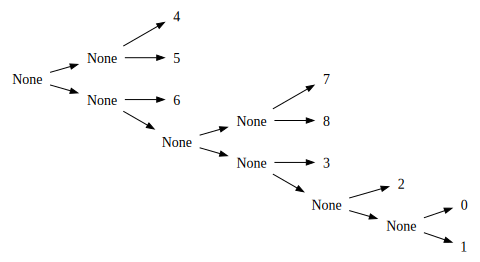

In [8]:
class TreeNode:
    """
    A class used to represent the guide trees used for the small parsimony agorithm
    """
    def __init__(self, label):
        self.label = label
        self.children = []

    def add_child(self, child):
        assert isinstance(child, TreeNode)
        self.children.append(child)

    def _add_to_graphviz(self, dot, index=1):
        node_id = f'node{index}'
        dot.node(node_id, str(self.label))
        index += 1

        for child in self.children:
            child_index = index
            child_node_id = f'node{child_index}'
            index = child._add_to_graphviz(dot, child_index)
            dot.edge(node_id, child_node_id)

        return index

    def dot(self):
        dot = graphviz.Digraph('Tree')
        graph_attr={'rankdir': 'LR', 'ranksep': '0.4'}
        node_attr={'shape': 'plaintext', 'width': '0.1', 'height': '0.1'}
        edge_attr={'arrowsize': '0.75'}
        dot.graph_attr.update(graph_attr)
        dot.node_attr.update(node_attr)
        dot.edge_attr.update(edge_attr)

        self._add_to_graphviz(dot)
        return dot

    @classmethod
    def from_string(cls, s):
        def parse_subtree(subtree_str):
            subtree_str = subtree_str.strip()
            if subtree_str.startswith('('):
                subtree_str = subtree_str[1:-1]
                node = TreeNode(None)
                children_strs = split_children(subtree_str)
                for child_str in children_strs:
                    node.add_child(parse_subtree(child_str))
                return node
            else:
                return TreeNode(int(subtree_str))

        def split_children(subtree_str):
            children = []
            paren_level = 0
            last_comma = -1
            for i, char in enumerate(subtree_str):
                if char == '(':
                    paren_level += 1
                elif char == ')':
                    paren_level -= 1
                elif char == ',' and paren_level == 0:
                    children.append(subtree_str[last_comma+1:i].strip())
                    last_comma = i
            children.append(subtree_str[last_comma+1:].strip())
            return children

        return parse_subtree(s)

    @classmethod
    def from_tuple(cls, t):
        if isinstance(t, int):
            return TreeNode(t)
        else:
            root = TreeNode(None)
            for child_tuple in t:
                root.add_child(TreeNode.from_tuple(child_tuple))
            return root

    def to_tuple(self):
        if self.label is None:
            return tuple(child.to_tuple() for child in self.children)
        else:
            return int(self.label)

# Example:
tree_tuple = ((4, 5), (6, ((7, 8), (3, (2, (0, 1))))))
tree = TreeNode.from_tuple(tree_tuple)
tree.dot()


## Nearest Neighbors interchange naive : returns the list of all subtrees

In [9]:
def nni_node_all(node):
    """
    Naive method for nearest neighbors interchange : return all the possible subtrees

    Args:
      node : the node we want to obtain all the subtrees from

    Returns:
      subtrees_ : a list containing all the subtrees of node we can obtain thanks to nni
    """
    subtrees_ = [node]
    if len(node.children) == 2 and all(len(child.children) == 2 for child in node.children):
        subtrees_ = []
        children0 = nni_node_all(node.children[0])
        children1 = nni_node_all(node.children[1])
        for child0 in children0:
            for child1 in children1:
                new_node = copy.deepcopy(node)
                new_node.children[0] = child0
                new_node.children[1] = child1
                subtrees_.append(new_node) #No change : 1st version
                new_node2 = copy.deepcopy(new_node)
                new_node2.children[0].children[0], new_node2.children[1].children[0] = child1.children[0], child0.children[0]
                subtrees_.append(new_node2) #2nd version
                new_node3 = copy.deepcopy(new_node)
                new_node3.children[0].children[0], new_node3.children[1].children[1] = child1.children[1], child0.children[0]
                subtrees_.append(new_node3) #3rd version
    elif len(node.children) ==2 :
        subtrees_ = []
        children0 = nni_node_all(node.children[0])
        children1 = nni_node_all(node.children[1])
        for child0 in children0:
            for child1 in children1:
                new_node = copy.deepcopy(node)
                new_node.children[0], new_node.children[1] = child0, child1
                subtrees_.append(new_node)

    return subtrees_


3


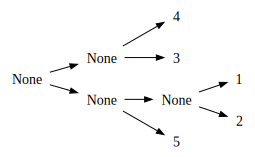

In [10]:
#Quick test to check our first nni algorithm
tree_test = TreeNode.from_tuple((((1,2),3),(4,5)))
l = nni_node_all(tree_test)
print(len(l))
l[1].dot()

## Nearest Neighbors interchange : a more optimized version of the NNI method, this algorithm doesn't try all the subtrees but compute the parsimony score of the substructure and only keeps the best substructure to create the larger structures

In [11]:
def nni_node_optimized(node, msa):
    """
    A more optimized version of the NNI method, this algorithm doesn't try all the subtrees but compute the parsimony score of the substructure and only keeps the best substructure to create the larger structures

    Args:
      node : the node we want to obtain the best subtree from
      msa : the multiple alignment linked to our node / tree

    Returns:
      best_score : the best small parsimony score obtainable thanks to the nni method
      best_structure : the node structure linked to the previous score
    """
    if len(node.children) <= 1 or all(len(child.children) < 2 for child in node.children):
        score = 1
        return score, node

    _, best_score = small_parsimony(msa, node.to_tuple())
    best_structure = node

    if len(node.children) == 2 and all(len(child.children) == 2 for child in node.children):
        _, child0 = nni_node_optimized(node.children[0],msa)
        _, child1 = nni_node_optimized(node.children[1],msa)
        new_node = copy.deepcopy(node) #No change : 1st version
        new_node.children[0] = child0
        new_node.children[1] = child1
        _, temp_score1 = small_parsimony(msa, new_node.to_tuple())
        if temp_score1 < best_score:
            best_score = temp_score1
            best_structure = new_node
        new_node2 = copy.deepcopy(new_node) #2nd version
        new_node2.children[0].children[0], new_node2.children[1].children[0] = child1.children[0], child0.children[0]
        _, temp_score2 = small_parsimony(msa, new_node2.to_tuple())
        if temp_score2 < best_score:
            best_score = temp_score2
            best_structure = new_node2
        new_node3 = copy.deepcopy(new_node) #3rd version
        new_node3.children[0].children[0], new_node3.children[1].children[1] = child1.children[1], child0.children[0]
        _, temp_score3 = small_parsimony(msa, new_node3.to_tuple())
        if temp_score3 < best_score:
            best_score = temp_score3
            best_structure = new_node3
    else :
        _, child0 = nni_node_optimized(node.children[0], msa)
        _, child1 = nni_node_optimized(node.children[1], msa)
        new_node = copy.deepcopy(node) #3rd version
        new_node.children[0], new_node.children[1] = child0, child1
        _, temp_score = small_parsimony(msa, new_node.to_tuple())
        if temp_score < best_score:
            best_score = temp_score
            best_structure = new_node
    return best_score, best_structure


# Implementation of pruning and regraphting strategy

In [12]:
def collect_subtrees(node, subtrees):
  '''
  Returns all the possible subtrees

  Args:
    node : the node we want to obtain the subtrees from
    subtrees : the list we want to fill

  Returns:
    Nothing, it fills the subtrees list
  '''
  if len(node.children) == 2:
    collect_subtrees(node.children[0], subtrees)
    collect_subtrees(node.children[1], subtrees)
    subtrees.append(node)


def find_and_remove_subtree(node, subtree):
  '''Finds the subtree as input and remove it from the tree'''
  if len(node.children) == 2:
    if node.children[0] == subtree:
      node = node.children[1]
    elif node.children[1] == subtree:
      node = node.children[0]
    else:
      node.children[0] = find_and_remove_subtree(node.children[0], subtree)
      node.children[1] = find_and_remove_subtree(node.children[1], subtree)
  return node


def regrapht_subtree(node, subtree):
  '''Adds the subtree as input at a random leaf'''
  if len(node.children) == 0:
    node.add_child(copy.deepcopy(node))
    node.label = None
    node.add_child(subtree)
  else:
    coin = np.random.uniform()
    if coin > 0.5:
      node.children[0] = regrapht_subtree(node.children[0], subtree)
    else:
      node.children[1] = regrapht_subtree(node.children[1], subtree)
  return node


def all_regrapht_subtree(origin, node, subtree, nodes):
  '''Adds the subtree as input at a random leaf'''
  if len(node.children) == 0:
    node.add_child(copy.deepcopy(node))
    node.label = None
    node.add_child(subtree)
    nodes.append(origin)
  else:
    origin2 = copy.deepcopy(origin)
    all_regrapht_subtree(origin2, node.children[0], subtree, nodes)
    origin3 = copy.deepcopy(origin)
    all_regrapht_subtree(origin3, node.children[1], subtree, nodes)


def prune_and_regrapht(node):
  '''Moves a random subtree at a random position'''
  if len(node.children) == 2:
    node2 = copy.deepcopy(node)
    subtrees = list()
    collect_subtrees(node2.children[0], subtrees)
    collect_subtrees(node2.children[1], subtrees)
    random_subtree = rd.choice(subtrees)
    node2 = find_and_remove_subtree(node2, random_subtree)
    node2 = regrapht_subtree(node2, random_subtree)
    return node2


def prune_and_regrapht_all(node):
  '''Moves a random subtree at all possible positions'''
  nodes = list()
  if len(node.children) == 2:
    if len(node.children[0].children) == 2 or len(node.children[1].children) == 2:
      node2 = copy.deepcopy(node)
      subtrees = list()
      collect_subtrees(node2.children[0], subtrees)
      collect_subtrees(node2.children[1], subtrees)
      random_subtree = rd.choice(subtrees)
      node2 = find_and_remove_subtree(node2, random_subtree)
      all_regrapht_subtree(node2, node2, random_subtree, nodes)
  return nodes


In [13]:
def prune_and_regrapht_greedy(node, n, msa):
  """
  A method to obtain a better structure by pruning and regraphting our current best structure
  """
  _, best_score = small_parsimony(msa, node.to_tuple())
  best_struc = node
  for i in range(n):
    new_node = prune_and_regrapht(best_struc)
    _, new_score = small_parsimony(msa, new_node.to_tuple())
    if new_score < best_score:
      best_score = new_score
      best_struc = new_node
  return best_score, best_struc


def prune_and_regrapht_naive(node, n, msa):
  """
  A method to obtain a better structure by pruning and regraphting our first structure (node)
  """
  _, best_score = small_parsimony(msa, node.to_tuple())
  best_struc = node
  for i in range(n):
    new_node = prune_and_regrapht(node)
    _, new_score = small_parsimony(msa, new_node.to_tuple())
    if new_score < best_score:
      best_score = new_score
      best_struc = new_node
  return best_score, best_struc


def prune_and_regrapht_exhaustive(node, n, msa):
  """
  A method to obtain a better structure by pruning and regraphting our first structure (node)
  However, unlike the previous one, this method tries all the possible positions of the random subtree moved by the pruning and regraphting
  """
  _, best_score = small_parsimony(msa, node.to_tuple())
  best_struc = node
  for i in range(n):
    nodes = prune_and_regrapht_all(best_struc)
    for new_node in nodes:
      _, new_score = small_parsimony(msa, new_node.to_tuple())
      if new_score < best_score:
        best_score = new_score
        best_struc = new_node
  return best_score, best_struc

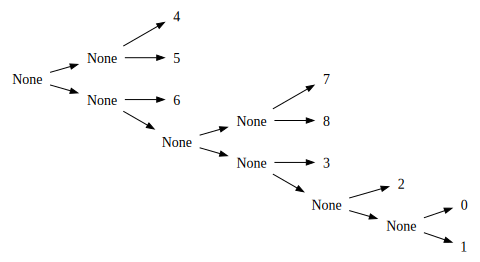

In [14]:
#A quick test of our previous algorithm
tree_tuple = ((4, 5), (6, ((7, 8), (3, (2, (0, 1))))))
tree = TreeNode.from_tuple(tree_tuple)
tree.dot()

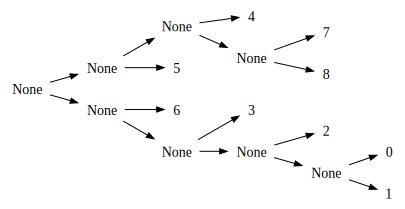

In [15]:
new_tree = prune_and_regrapht(tree)
new_tree.dot()

# Generation of inputs

In [16]:
def generate_seq_aligned_naive(n,k):
    """
    Generates an aligned set of k sequences of length n

    Input -> n : the length of the desired alignment
             k : the number of sequences in the alignment

    Output -> alignment : an array containing all the sequences aligned

    """
    alignment = []
    bases = ["A", "C", "T", "G"]
    epsilon_indel = 0.05
    epsilon_mut = 0.1
    seq = ""
    for _ in range(n):
        if np.random.rand()<epsilon_indel:
            seq+="-"
        else :
            i = np.random.randint(4)
            seq+=bases[i]
    alignment.append(seq)
    for _ in range(k-1):
        seq = ""
        for j in range(n):
            if np.random.rand()<epsilon_indel:
                seq = seq + "-"
            elif np.random.rand()<epsilon_mut :
                i = np.random.randint(4)
                seq = seq+ bases[i]
            else :
                seq= seq + alignment[0][j]
        alignment.append(seq)
    return alignment

print(generate_seq_aligned_naive(15,4))

['GTTATCACGGTGGGC', 'GTTATCACTGTGGGC', 'GATATCACGCTGGGC', 'GTTATCACGG-GGGC']


In [17]:
def generate_seq_aligned(n,k):
    """
    Generates an aligned set of k sequences of length n but differentiates the probabilities of extending and creating a gap

    Input -> n : the length of the desired alignment
             k : the number of sequences in the alignment

    Output -> alignment : an array containing all the sequences aligned

    """
    alignment = []
    bases = ["A", "C", "T", "G"]
    epsilon_indel = 0.05
    epsilon_mut = 0.1
    seq = ""
    for _ in range(n):
        if np.random.rand()<epsilon_indel:
            seq+="-"
            if epsilon_indel == 0.05:
                epsilon_indel = 0.4
            else :
                epsilon_indel = epsilon_indel * 0.9
        else :
            if epsilon_indel != 0.05:
              epsilon_indel = 0.05
            i = np.random.randint(4)
            seq+=bases[i]
    alignment.append(seq)
    for _ in range(k-1):
        seq = ""
        for j in range(n):
            if np.random.rand()<epsilon_indel:
                seq = seq + "-"
                if epsilon_indel == 0.05:
                    epsilon_indel = 0.4
                else :
                    epsilon_indel = epsilon_indel * 0.9
            elif np.random.rand()<epsilon_mut or (alignment[0][j]=="-" and np.random.rand()<0.7):
                if epsilon_indel != 0.05:
                  epsilon_indel = 0.05
                i = np.random.randint(4)
                seq = seq+ bases[i]
            else :
                if epsilon_indel != 0.05:
                  epsilon_indel = 0.05
                seq= seq + alignment[0][j]
        alignment.append(seq)
    return alignment

print(generate_seq_aligned(15,4))

['TCTGCTGATGGGAAC', 'TCTGCTAA-GGGAAC', 'TC-GCTGATGGG-AC', 'TTTGCTGATGGGAAC']


In [18]:
def generate_seq_unaligned_naive(n,k):
    """
    Generates a set of k unaligned sequences of size approximately n

    Input -> n : the approximated length of the desired alignment
             k : the number of sequences in the alignment

    Output -> alignment : an array containing all the sequences aligned

    """
    alignment = []
    bases = ["A", "C", "T", "G"]
    epsilon_mut = 0.05
    seq = ""
    sigma = n//8
    length = int(np.random.normal(loc = n, scale = sigma))
    for _ in range(length):
        i = np.random.randint(4)
        seq+=bases[i]
    alignment.append(seq)
    for _ in range(k-1):
        seq = ""
        length = int(np.random.normal(loc = n, scale = sigma))
        for j in range(length):
            if np.random.rand()<epsilon_mut or j >= len(alignment[0]):
                i = np.random.randint(4)
                seq = seq+ bases[i]
            else :
                seq= seq + alignment[0][j]
        alignment.append(seq)
    return alignment

print(generate_seq_unaligned_naive(20,4))

['AACGAAGCCCACAGTCT', 'AACGAAGCCCACAGTCTGGTC', 'AACGAAGCCCAGAGTCTTT', 'AACGAAGCCCACAGTCTACGGA']


## Using BioPython :

In [19]:
def extend_or_truncate_sequence(reference_seq, target_length):
    """
    Extends or truncates a reference sequence to the length target_length

    Args:
      reference_seq : the sequence to modify
      target_length : the length to obtain

    Returns:
      extended_seq : the modified version of reference_seq with len(extended_seq) = target_length
    """
    seq_len = len(reference_seq)
    if seq_len < target_length:
        factor = (target_length + seq_len - 1) // seq_len
        extended_seq = (reference_seq * factor)[:target_length]
    else:
        extended_seq = reference_seq[:target_length]
    return extended_seq


def generate_similar_sequences(reference_seq, num_sequences, mutation_rate, target_length):
    """
    Generates a set of num_sequences similar to the sequence reference_seq of length target_length

    Args:
      reference_seq : the reference sequence for our generation
      num_sequences : the number of sequences we want in our set
      mutation_rate : the rate of mutation in our set
      target_length : the length of each sequence in our set

    Returns:
      sequences : a list containing our set of sequences
    """
    extended_ref_seq = extend_or_truncate_sequence(reference_seq, target_length)
    sequences = [extended_ref_seq]

    for _ in range(num_sequences - 1):
        new_seq = list(extended_ref_seq)
        for i in range(target_length):
            if rd.random() < mutation_rate:
                bases = ['A', 'C', 'G', 'T']
                bases.remove(extended_ref_seq[i])
                new_base = rd.choice(bases)
                new_seq[i] = new_base
        sequences.append(Seq(''.join(new_seq)))

    return sequences


# Example
reference_seq = Seq("ATCGATCGATCGATCG")
num_sequences = 5
mutation_rate = 0.3
target_length = 20

similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, target_length)
for seq in similar_sequences:
    print(seq)


ATCGATCGATCGATCGATCG
ATCGATGGATGAATAGATAA
CACGATAGAGCCGTGGGTCG
ATCGTTCGATCCTTCGACAG
CTCGAGCGCTCGGATGATCG


#NNI on our generated sequences

## Testing NNI

New best score:  43
Best structure: <__main__.TreeNode object at 0x00000279B4A5ECD0>
Best score: 43


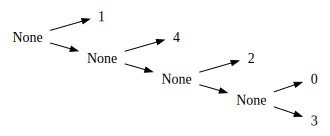

In [20]:
#Generate sequences using biopython
reference_seq = Seq("ATCGATCGATCGATCG")
num_sequences = 5
mutation_rate = 0.3

similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, 20)

#Build a tree
w = example_w
matrix = distance_matrix(similar_sequences, w)
guide_tree_ = guide_tree(similar_sequences, w)
guide_tree_node = TreeNode.from_tuple(guide_tree_)

#NNI
aligned_sequences, _ = progressive_alignment(similar_sequences, w)
subtrees_all = nni_node_all(guide_tree_node)

#Best score
best_score_all = np.Inf
best_tree=subtrees_all[0]
for subtree in subtrees_all :
  _, score = small_parsimony(aligned_sequences, subtree.to_tuple())
  if score < best_score_all :
      print("New best score: ", score)
      best_score_all = score
      best_tree=subtree
print("Best structure:", best_tree)
print("Best score:", best_score_all)
best_tree.dot()


In this small example, the test browse all the possible subtrees and pick the best one. This strategy is brute-force.

## Testing NNI optimized

Best structure: <__main__.TreeNode object at 0x00000279B4A4C210>
Best score: 46


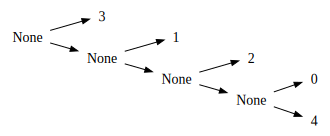

In [21]:
#Generate sequences using biopython
reference_seq = Seq("ATCGATCGATCGATCG")
num_sequences = 5
mutation_rate = 0.3

similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, 20)

#Build a tree
w = example_w
matrix = distance_matrix(similar_sequences, w)
guide_tree_ = guide_tree(similar_sequences, w)
guide_tree_node = TreeNode.from_tuple(guide_tree_)

#Alignment
aligned_sequences, _ = progressive_alignment(similar_sequences, w)

#NNI node optimized
best_score, best_structure = nni_node_optimized(guide_tree_node, aligned_sequences)
print("Best structure:", best_structure)
print("Best score:", best_score)
best_structure.dot()


Here, this version of the nearsest neighbor interchange strategy is greedy. At each depth or branch of the tree we only pick the subtree with the minimal parsimony score instead of trying all the possible subtrees. This version is quicker as we skip a lot of subtrees but might not be optimal. In order to reach the global minimum, we might go through a local maximum.

#Comparison of naive NNI and NNI optimized

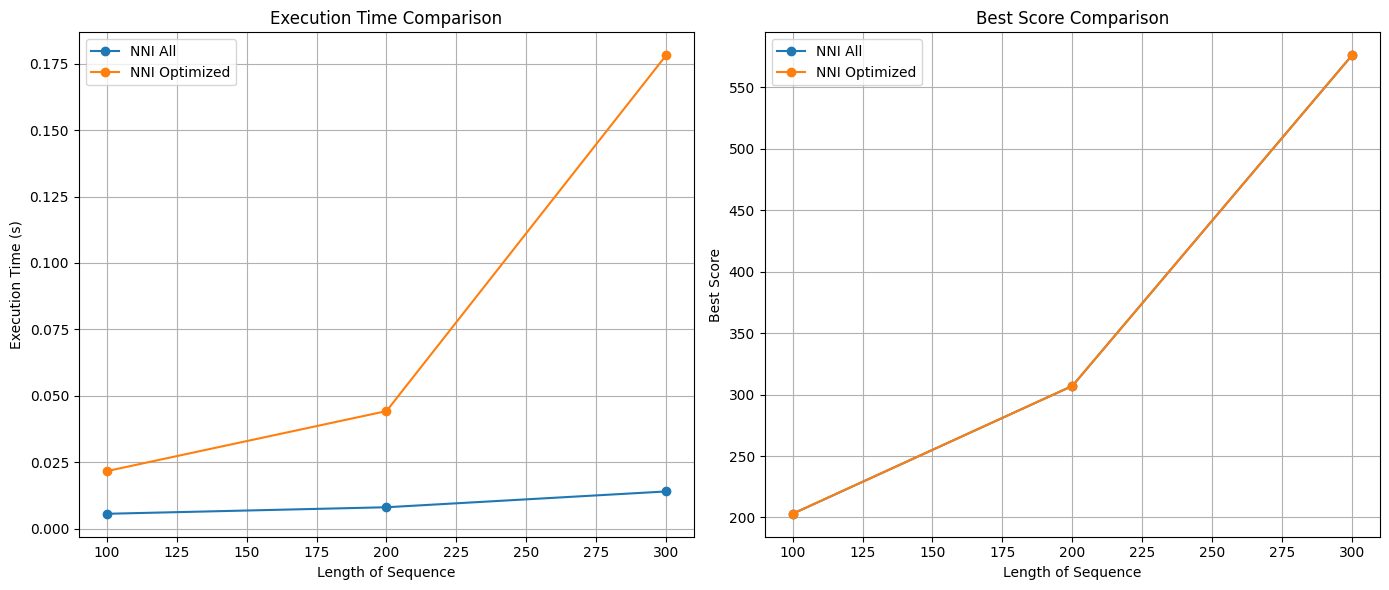

In [22]:
reference_seq = Seq("ATCGATCGATCGATCG")
def compare_nni_functions(sequence_lengths, num_sequences=5, mutation_rate=0.3):
    """
    A function wich compares the performance of our algorithms nni_all and nni_optimized on random generated sets of sequences

    Args:
      sequence_lengths : a list of the length of the sequences in our generated sets
      num_sequences : the number of sequences in our generated set (5 by default)
      mutation_rate : the mutation rate in our set (0.3 by default)

    Returns:
      sequence_length : the length of our sequences (the same value as our argument)
      times_all : a list the execution time of our algorithm nni_all for each set
      times_optimized : a list the execution time of our algorithm nni_optimized for each set
      scores_all : a list of the best score found by nni_all for each set
      scores_optimized : a list of the best score found by nni_optimized for each set
    """
    times_all = []
    times_optimized = []
    scores_all = []
    scores_optimized = []

    for length in sequence_lengths: # For each set
        similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, length)
        msa, _ = progressive_alignment(similar_sequences, example_w)
        guide_tree_ = guide_tree(similar_sequences, example_w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        start_time_all = time.time()
        subtrees_all = nni_node_all(guide_tree_node)
        best_score_all = np.Inf
        for subtree in subtrees_all :
          _, score = small_parsimony(msa, subtree.to_tuple())
          if score < best_score_all : #Only keeps the best score
            best_score_all = score
        end_time_all = time.time()

        start_time_opt = time.time()
        best_score_opt, _ = nni_node_optimized(guide_tree_node, msa)
        end_time_opt = time.time()

        times_all.append(end_time_all - start_time_all)
        times_optimized.append(end_time_opt - start_time_opt)
        scores_all.append(best_score_all)
        scores_optimized.append(best_score_opt)

    return sequence_lengths, times_all, times_optimized, scores_all, scores_optimized

sequence_lengths = [100, 200, 300]
results = compare_nni_functions(sequence_lengths)
lengths, times_all, times_optimized, scores_all, scores_optimized = results

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lengths, times_all, label='NNI All', marker='o')
plt.plot(lengths, times_optimized, label='NNI Optimized', marker='o')
plt.xlabel('Length of Sequence')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lengths, scores_all, label='NNI All', marker='o')
plt.plot(lengths, scores_optimized, label='NNI Optimized', marker='o')
plt.xlabel('Length of Sequence')
plt.ylabel('Best Score')
plt.title('Best Score Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In this test, we can observe that both the brute-force and the greedy strategies produce the same results. Thus, they are very efficient. As for the execution time, the greedy strategy seems more expensive in computation time. This might be dure to the extra comparisons required at each branch of the tree exploration.

# Comparison between nni_all and prune_and_regrapht

Best score prune = 26 and Best score NNI = 196
Best score prune = 80 and Best score NNI = 388
Best score prune = 209 and Best score NNI = 511
Best score prune = 304 and Best score NNI = 714
Best score prune = 149 and Best score NNI = 890


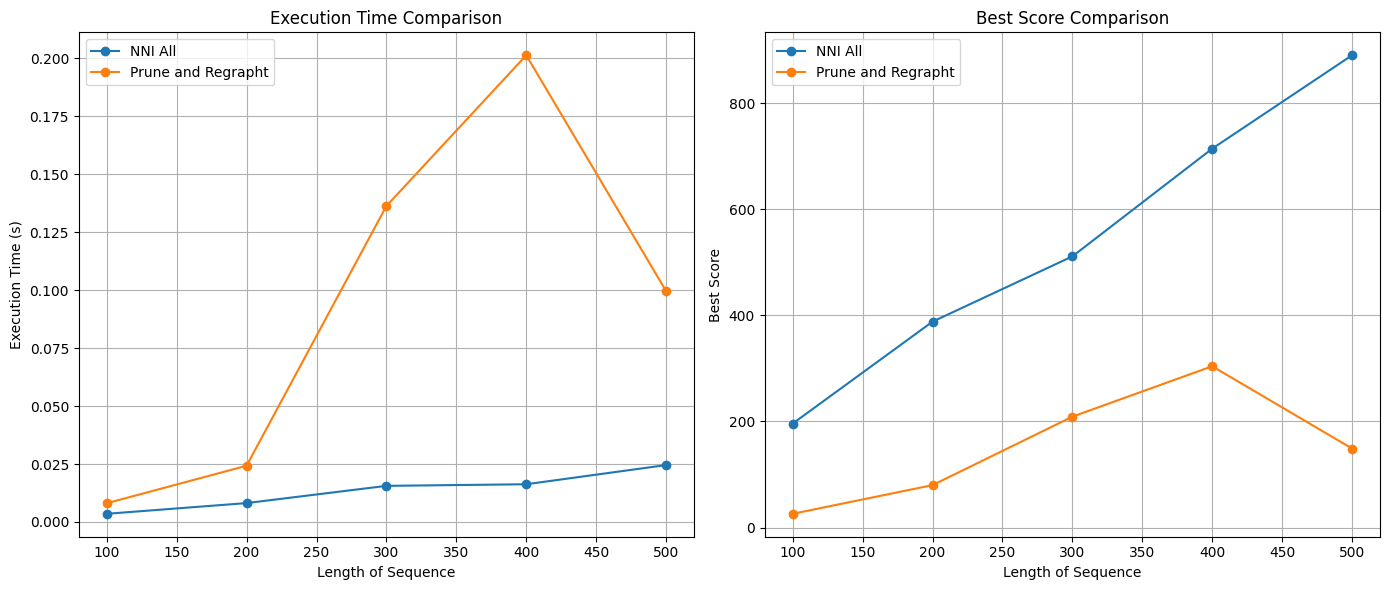

In [23]:
reference_seq = Seq("ATCGATCGATCGATCG")
def compare_nni_prune_functions(sequence_lengths, num_sequences=5, mutation_rate=0.3, n_prune = 10):
    """
    A function wich compares the performance of our algorithms nni and prune_and_regrapht on random generated sets of sequences

    Args:
      sequence_lengths : a list of the length of the sequences in our generated sets
      num_sequences : the number of sequences in our generated set (5 by default)
      mutation_rate : the mutation rate in our set (0.3 by default)
      n_prune : the number of subtrees we want to move in our prune_and_regrapht method (10 by default)

    Returns:
      sequence_length : the length of our sequences (the same value as our argument)
      times_all : a list the execution time of our algorithm nni_all for each set
      times_prune : a list the execution time of our algorithm prune_and_regrapht for each set
      scores_all : a list of the best score found by nni_all for each set
      scores_prune : a list of the best score found by prune_and_regrapht for each set
    """
    times_all = []
    times_prune = []
    scores_all = []
    scores_prune = []

    for length in sequence_lengths:
        similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, length)
        msa, _ = progressive_alignment(similar_sequences, example_w)
        guide_tree_ = guide_tree(similar_sequences, example_w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        start_time_all = time.time()
        subtrees_all = nni_node_all(guide_tree_node)
        best_score_all = np.Inf
        for subtree in subtrees_all :
          _, score = small_parsimony(msa, subtree.to_tuple())
          if score < best_score_all :
            best_score_all = score
        end_time_all = time.time()

        start_time_prune = time.time()
        best_score_prune, _ = prune_and_regrapht_exhaustive(guide_tree_node, n_prune, msa)
        end_time_prune = time.time()

        times_all.append(end_time_all - start_time_all)
        times_prune.append(end_time_prune - start_time_prune)
        scores_all.append(best_score_all)
        scores_prune.append(best_score_prune)

        print(f'Best score prune = {best_score_prune} and Best score NNI = {best_score_all}')

    return sequence_lengths, times_all, times_prune, scores_all, scores_prune

sequence_lengths = [100, 200, 300, 400, 500]
results = compare_nni_prune_functions(sequence_lengths)
lengths, times_all, times_prune, scores_all, scores_prune = results

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lengths, times_all, label='NNI All', marker='o')
plt.plot(lengths, times_prune, label='Prune and Regrapht', marker='o')
plt.xlabel('Length of Sequence')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lengths, scores_all, label='NNI All', marker='o')
plt.plot(lengths, scores_prune, label='Prune and Regrapht', marker='o')
plt.xlabel('Length of Sequence')
plt.ylabel('Best Score')
plt.title('Best Score Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In this test, we compare the brute-force nearest neighbor strategy against the prune and regrapht strategy. The version of the prune and regrapht strategy is also greedy because we repeat `n_prune` times the following process. We randomly pick a subtree and we find its best location in terms of parsimony score. This strategy has more possibilities anbd is thus more expensive in computation time. However, it produces better results.

# NNI Performance

##NNI_all

Studying NNI behavior on generated sequences of different sizes

Length: 100, Time: 0.0025310516357421875 seconds, Best Score: 217
Length: 200, Time: 0.010565042495727539 seconds, Best Score: 355
Length: 300, Time: 0.018661975860595703 seconds, Best Score: 575
Length: 400, Time: 0.020182371139526367 seconds, Best Score: 717
Length: 500, Time: 0.026007652282714844 seconds, Best Score: 948


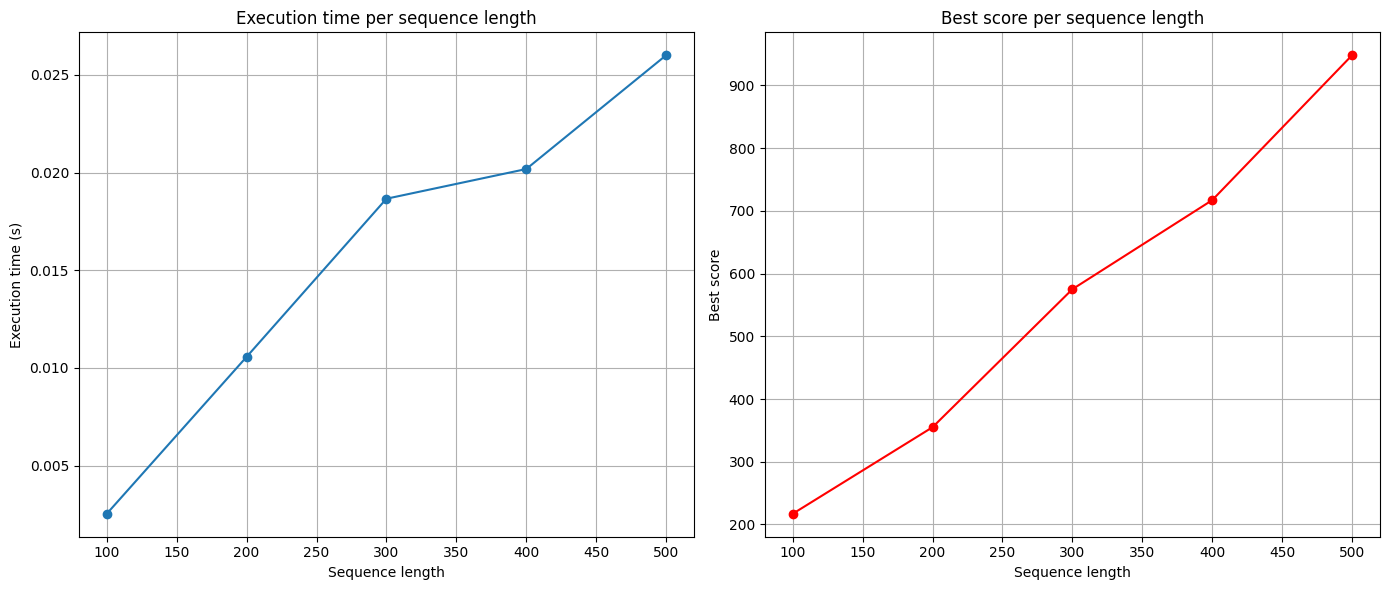

In [24]:
reference_seq = Seq("ATCGATCGATCGATCG")
def profile_performance(sequence_lengths, num_sequences=5, mutation_rate=0.3):
    times = []
    best_scores = []
    for length in sequence_lengths:
        similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, length)

        w = example_w
        matrix = distance_matrix(similar_sequences, w)
        msa, _ = progressive_alignment(similar_sequences, example_w)
        guide_tree_ = guide_tree(similar_sequences, w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        start_time = time.time()
        subtrees_all = nni_node_all(guide_tree_node)
        best_score = np.Inf
        for subtree in subtrees_all :
          _, score = small_parsimony(msa, subtree.to_tuple())
          if score < best_score :
            best_score = score
        end_time = time.time()

        times.append(end_time - start_time)
        best_scores.append(best_score)

        print(f"Length: {length}, Time: {end_time - start_time} seconds, Best Score: {best_score}")
    return sequence_lengths, times, best_scores

sequence_lengths = [100, 200, 300, 400, 500]
lengths, times, best_scores = profile_performance(sequence_lengths)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lengths, times, marker='o')
plt.title('Execution time per sequence length')
plt.xlabel('Sequence length')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lengths, best_scores, marker='o', color='red')
plt.title('Best score per sequence length')
plt.xlabel('Sequence length')
plt.ylabel('Best score')
plt.grid(True)

plt.tight_layout()
plt.show()

Both the execution time and the parsimony scores increase linearly with the sequence length.

Studying NNI behavior on generated sequences with different mutation rates

Mutation rate: 0.001, Time: 0.019263505935668945 seconds, Best Score: 3
Mutation rate: 0.01, Time: 0.004029750823974609 seconds, Best Score: 17
Mutation rate: 0.05, Time: 0.008057355880737305 seconds, Best Score: 84
Mutation rate: 0.1, Time: 0.006398200988769531 seconds, Best Score: 156
Mutation rate: 0.3, Time: 0.008469343185424805 seconds, Best Score: 395
Mutation rate: 0.5, Time: 0.008011102676391602 seconds, Best Score: 472
Mutation rate: 0.9, Time: 0.1534116268157959 seconds, Best Score: 503


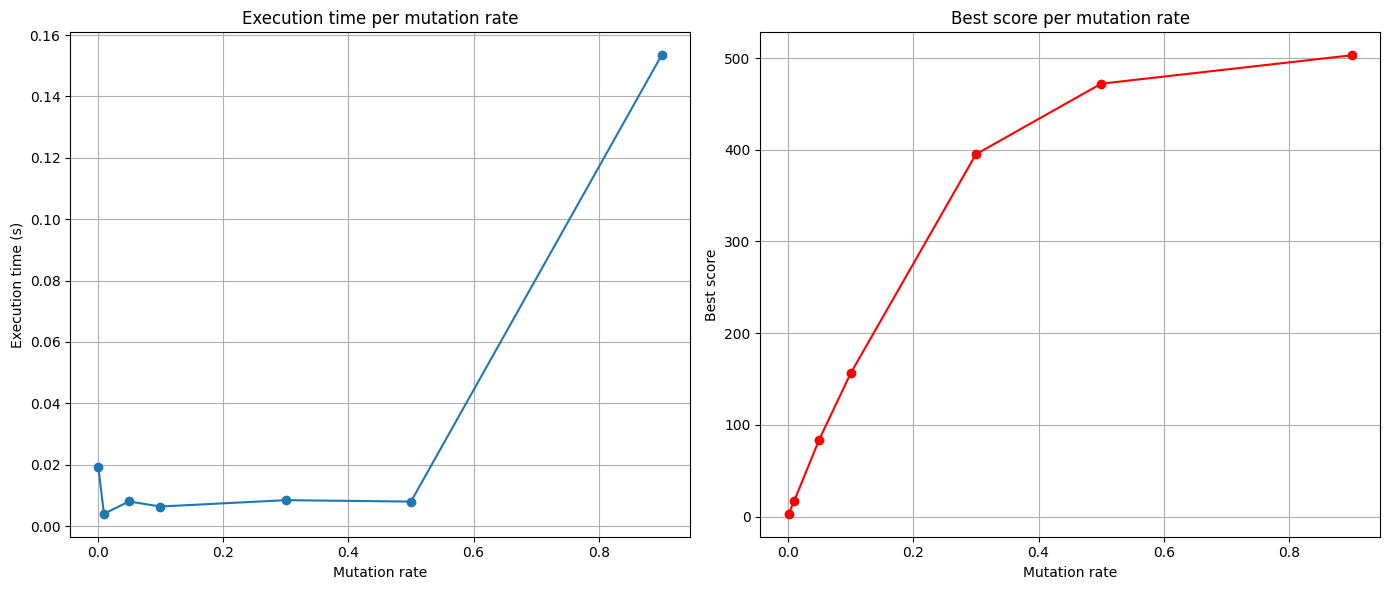

In [25]:
reference_seq = Seq("ATCGATCGATCGATCG")
def profile_performance( mutation_rates, sequence_length=200, num_sequences=5):
    times = []
    best_scores = []
    for mutation_rate in mutation_rates:
        similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, sequence_length)

        w = example_w
        matrix = distance_matrix(similar_sequences, w)
        msa, _ = progressive_alignment(similar_sequences, example_w)
        guide_tree_ = guide_tree(similar_sequences, w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        start_time = time.time()
        subtrees_all = nni_node_all(guide_tree_node)
        best_score = np.Inf
        for subtree in subtrees_all :
          _, score = small_parsimony(msa, subtree.to_tuple())
          if score < best_score :
            best_score = score
        end_time = time.time()

        times.append(end_time - start_time)
        best_scores.append(best_score)

        print(f"Mutation rate: {mutation_rate}, Time: {end_time - start_time} seconds, Best Score: {best_score}")
    return mutation_rates, times, best_scores

mutation_rates = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.9]
mutation_rates, times, best_scores = profile_performance(mutation_rates)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(mutation_rates, times, marker='o')
plt.title('Execution time per mutation rate')
plt.xlabel('Mutation rate')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mutation_rates, best_scores, marker='o', color='red')
plt.title('Best score per mutation rate')
plt.xlabel('Mutation rate')
plt.ylabel('Best score')
plt.grid(True)

plt.tight_layout()
plt.show()

Both the execution time and the parsimony scores increase and then reach a plateau with the mutation rate.

##NNI_optimized

Studying NNI behavior on generated sequences of different sizes

Length: 100, Time: 0.021203279495239258 seconds, Best Score: 206
Length: 200, Time: 0.03978586196899414 seconds, Best Score: 357
Length: 300, Time: 0.06647229194641113 seconds, Best Score: 512
Length: 400, Time: 0.0923149585723877 seconds, Best Score: 656
Length: 500, Time: 0.12088251113891602 seconds, Best Score: 914


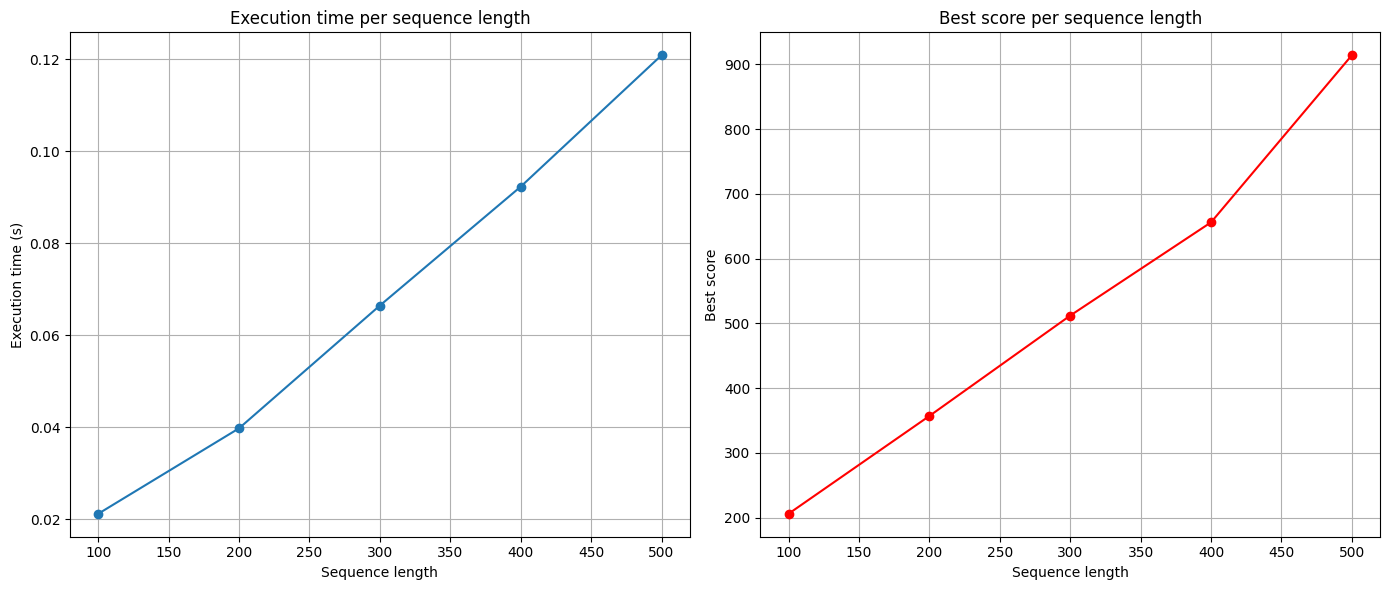

In [26]:
reference_seq = Seq("ATCGATCGATCGATCG")
def profile_performance(sequence_lengths, num_sequences=5, mutation_rate=0.3):
    times = []
    best_scores = []
    for length in sequence_lengths:
        similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, length)

        w = example_w
        matrix = distance_matrix(similar_sequences, w)
        guide_tree_ = guide_tree(similar_sequences, w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        msa, _ = progressive_alignment(similar_sequences, w)

        start_time = time.time()
        best_score, best_structure = nni_node_optimized(guide_tree_node, msa)
        end_time = time.time()

        times.append(end_time - start_time)
        best_scores.append(best_score)

        print(f"Length: {length}, Time: {end_time - start_time} seconds, Best Score: {best_score}")
    return sequence_lengths, times, best_scores

sequence_lengths = [100, 200, 300, 400, 500]
lengths, times, best_scores = profile_performance(sequence_lengths)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lengths, times, marker='o')
plt.title('Execution time per sequence length')
plt.xlabel('Sequence length')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lengths, best_scores, marker='o', color='red')
plt.title('Best score per sequence length')
plt.xlabel('Sequence length')
plt.ylabel('Best score')
plt.grid(True)

plt.tight_layout()
plt.show()


Both the execution time and the parsimony scores increase linearly with the sequence length.

Studying NNI behavior on generated sequences with different mutation rates

Mutation rate: 0.001, Time: 0.036216020584106445 seconds, Best Score: 0
Mutation rate: 0.01, Time: 0.03124380111694336 seconds, Best Score: 9
Mutation rate: 0.05, Time: 0.058365821838378906 seconds, Best Score: 83
Mutation rate: 0.1, Time: 0.03248858451843262 seconds, Best Score: 161
Mutation rate: 0.3, Time: 0.04078078269958496 seconds, Best Score: 380
Mutation rate: 0.5, Time: 0.057868242263793945 seconds, Best Score: 469
Mutation rate: 0.9, Time: 0.04933333396911621 seconds, Best Score: 523


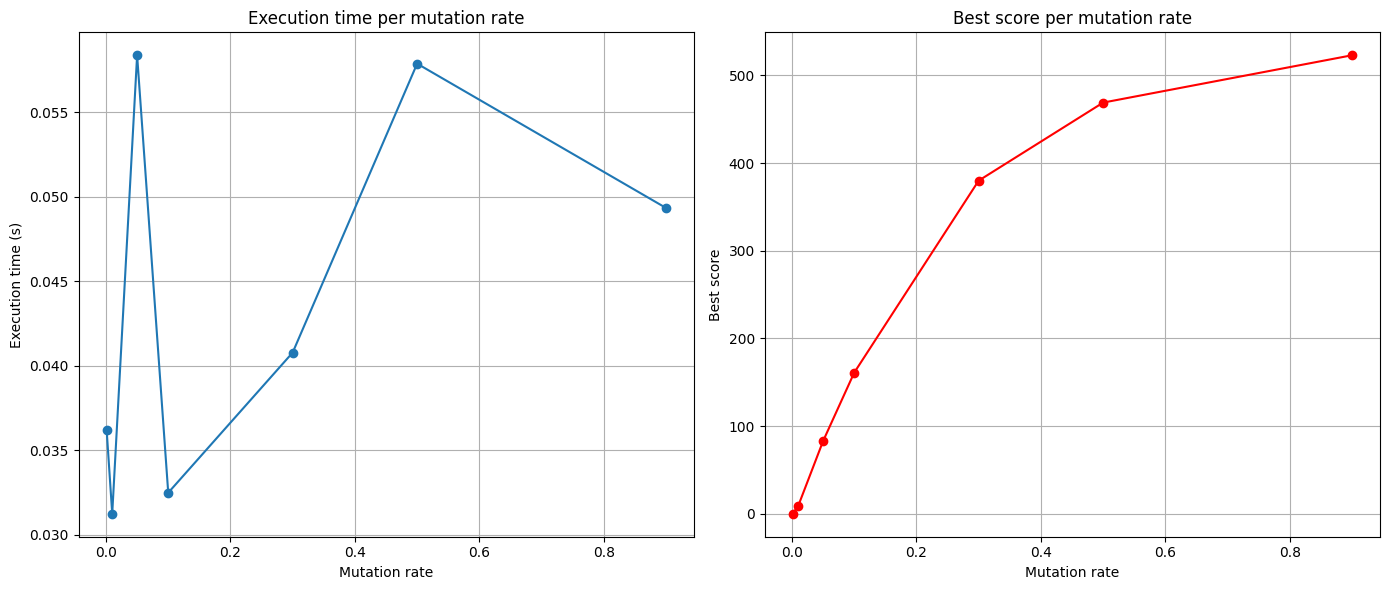

In [27]:
reference_seq = Seq("ATCGATCGATCGATCG")
def profile_performance( mutation_rates, sequence_length=200, num_sequences=5):
    times = []
    best_scores = []
    for mutation_rate in mutation_rates:
        similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, sequence_length)

        w = example_w
        matrix = distance_matrix(similar_sequences, w)
        guide_tree_ = guide_tree(similar_sequences, w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        msa, _ = progressive_alignment(similar_sequences, w)

        start_time = time.time()
        best_score, best_structure = nni_node_optimized(guide_tree_node, msa)
        end_time = time.time()

        times.append(end_time - start_time)
        best_scores.append(best_score)

        print(f"Mutation rate: {mutation_rate}, Time: {end_time - start_time} seconds, Best Score: {best_score}")
    return mutation_rates, times, best_scores

mutation_rates = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.9]
mutation_rates, times, best_scores = profile_performance(mutation_rates)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(mutation_rates, times, marker='o')
plt.title('Execution time per mutation rate')
plt.xlabel('Mutation rate')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mutation_rates, best_scores, marker='o', color='red')
plt.title('Best score per mutation rate')
plt.xlabel('Mutation rate')
plt.ylabel('Best score')
plt.grid(True)

plt.tight_layout()
plt.show()

Both the execution time and the parsimony scores increase linearly with the mutation rate. Overall, we get almost the same results for both the greedy and the brute-force strategies and this might be due to the fact that our samples are too small and that these two options can not differentiate.

# Prune and regrapht performance

Length: 100, Time: 0.025295019149780273 seconds, Best Score: 38
Length: 200, Time: 0.02437305450439453 seconds, Best Score: 55
Length: 300, Time: 0.020328044891357422 seconds, Best Score: 105
Length: 400, Time: 0.04169058799743652 seconds, Best Score: 137
Length: 500, Time: 0.15490221977233887 seconds, Best Score: 342


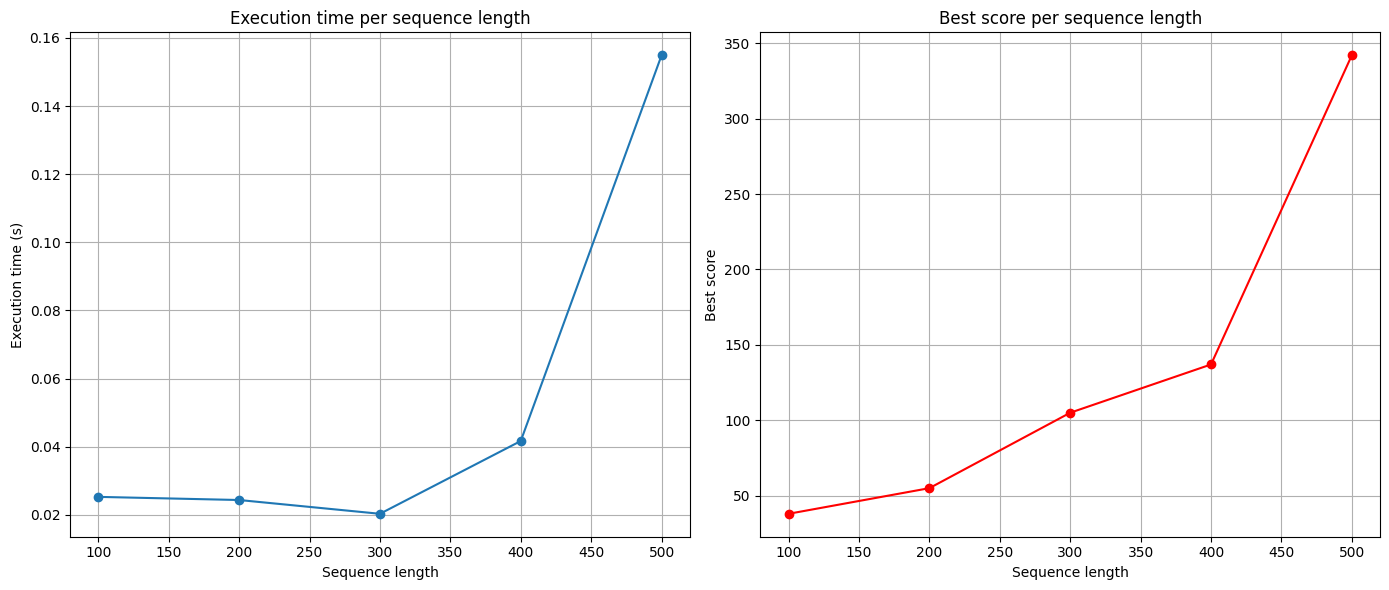

In [28]:
reference_seq = Seq("ATCGATCGATCGATCG")
def profile_performance(sequence_lengths, num_sequences=5, mutation_rate=0.3, n_prune=10):
    times = []
    best_scores = []
    for length in sequence_lengths:
        similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, length)

        w = example_w
        matrix = distance_matrix(similar_sequences, w)
        guide_tree_ = guide_tree(similar_sequences, w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        msa, _ = progressive_alignment(similar_sequences, w)

        start_time = time.time()
        best_score, _ = prune_and_regrapht_exhaustive(guide_tree_node, n_prune, msa)
        end_time = time.time()

        times.append(end_time - start_time)
        best_scores.append(best_score)

        print(f"Length: {length}, Time: {end_time - start_time} seconds, Best Score: {best_score}")
    return sequence_lengths, times, best_scores

sequence_lengths = [100, 200, 300, 400, 500]
lengths, times, best_scores = profile_performance(sequence_lengths)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lengths, times, marker='o')
plt.title('Execution time per sequence length')
plt.xlabel('Sequence length')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lengths, best_scores, marker='o', color='red')
plt.title('Best score per sequence length')
plt.xlabel('Sequence length')
plt.ylabel('Best score')
plt.grid(True)

plt.tight_layout()
plt.show()


Both the execution time and the parsimony scores increase almost linearly with the sequence length.

Mutation rate: 0.001, Time: 0.07486176490783691 seconds, Best Score: 0
Mutation rate: 0.01, Time: 0.04658007621765137 seconds, Best Score: 5
Mutation rate: 0.05, Time: 0.04505467414855957 seconds, Best Score: 28
Mutation rate: 0.1, Time: 0.05038261413574219 seconds, Best Score: 63
Mutation rate: 0.3, Time: 0.031088590621948242 seconds, Best Score: 72
Mutation rate: 0.5, Time: 0.0746755599975586 seconds, Best Score: 227
Mutation rate: 0.9, Time: 0.0693516731262207 seconds, Best Score: 266


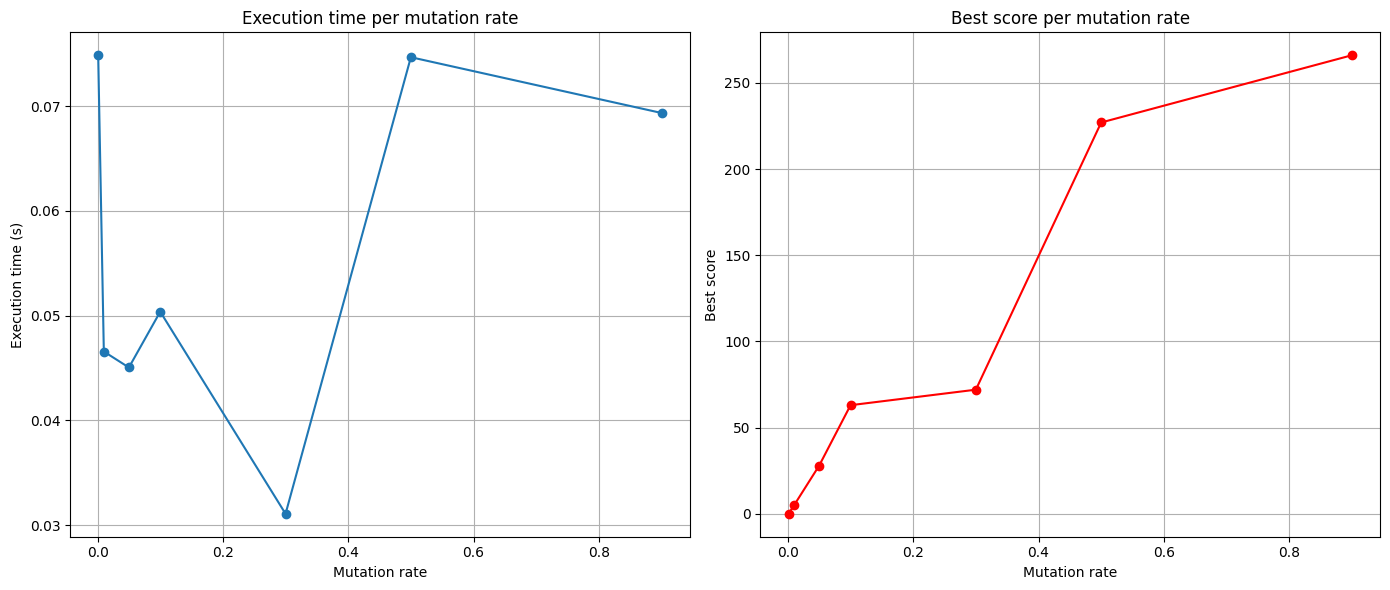

In [29]:
reference_seq = Seq("ATCGATCGATCGATCG")
def profile_performance( mutation_rates, sequence_length=200, num_sequences=5, n_prune=10):
    times = []
    best_scores = []
    for mutation_rate in mutation_rates:
        similar_sequences = generate_similar_sequences(reference_seq, num_sequences, mutation_rate, sequence_length)

        w = example_w
        matrix = distance_matrix(similar_sequences, w)
        guide_tree_ = guide_tree(similar_sequences, w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        msa, _ = progressive_alignment(similar_sequences, w)

        start_time = time.time()
        best_score, best_structure = prune_and_regrapht_exhaustive(guide_tree_node, n_prune, msa)
        end_time = time.time()

        times.append(end_time - start_time)
        best_scores.append(best_score)

        print(f"Mutation rate: {mutation_rate}, Time: {end_time - start_time} seconds, Best Score: {best_score}")
    return mutation_rates, times, best_scores

mutation_rates = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.9]
mutation_rates, times, best_scores = profile_performance(mutation_rates)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(mutation_rates, times, marker='o')
plt.title('Execution time per mutation rate')
plt.xlabel('Mutation rate')
plt.ylabel('Execution time (s)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mutation_rates, best_scores, marker='o', color='red')
plt.title('Best score per mutation rate')
plt.xlabel('Mutation rate')
plt.ylabel('Best score')
plt.grid(True)

plt.tight_layout()
plt.show()

Both the execution time and the parsimony scores seem to increase and then reach a plateau with the mutation rate.

# Tests on real alignments

In [30]:
def lire_fasta(nom_fichier):
    """
    Read a fasta file

    Args:
      nomfichier : the path of the fasta file

    Returns:
      a list of the alignment sequences of the fasta file
    """
    res = []
    alignment = AlignIO.read(nom_fichier, "fasta")
    for record in alignment:
        res.append(str(record.seq))
    return res

def lire_stockholm(nom_fichier):
    """
    Read a stockholm file

    Args:
      nomfichier : the path of the stockholm file

    Returns:
      a list of the alignment sequences of the stockholm file
    """
    res = []
    alignment = AlignIO.read(nom_fichier, "stockholm")
    for record in alignment:
        res.append(str(record.seq))
    return res

Length: 126, Time: 0.10860157012939453 seconds, Best Score: 611, Time Prune and Regrapht: 0.2731173038482666 seconds, Best Score Prune and Regrapht: 91
Length: 314, Time: 0.0676736831665039 seconds, Best Score: 353, Time Prune and Regrapht: 0.059992313385009766 seconds, Best Score Prune and Regrapht: 114
Length: 384, Time: 0.08459782600402832 seconds, Best Score: 1172, Time Prune and Regrapht: 0.08232927322387695 seconds, Best Score Prune and Regrapht: 98


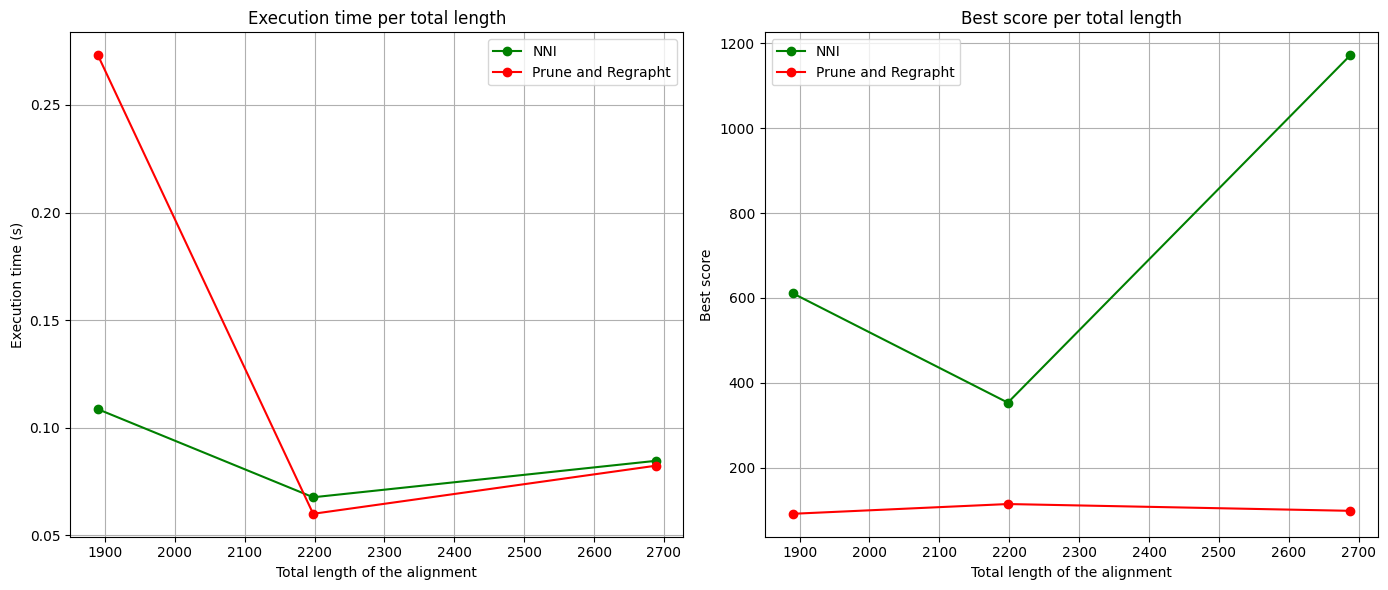

In [31]:
# You have to download the following alignments before running the test :
# "5S_rRNA.apsi-54.sci-95.no-1.ref.fa"
# "SRP_euk_arch.apsi-68.sci-83.no-1.ref.fa"
# "SRP_euk_arch.apsi-34.sci-67.no-1.ref.fa"

def profile_performance_on_file(name_files, n_prune = 15):
    """
    A function wich compares the performance of our algorithms nni and prune_and_regrapht on random generated sets of sequences

    Args:
      name_files : a list of couple containing : the name of each file we want to study, the type of the file ("fa" for a fasta file, "stk" for a stockholm file)
      n_prune : the number of subtrees we want to move in our prune_and_regrapht method (15 by default)

    Returns:
      lengthandnumber : a list of the size (length of sequences * number of sequences) of each set
      times : a list the execution time of our algorithm nni_all for each set
      times_prune : a list the execution time of our algorithm prune_and_regrapht for each set
      best_scores : a list of the best score found by nni_all for each set
      best_scores_prune : a list of the best score found by prune_and_regrapht for each set
    """
    times = []
    times_prune = []
    best_scores = []
    best_scores_prune = []
    lengthsandnumber = []
    for file_name, ty in name_files:
        similar_sequences = []
        if ty == "fa":
          similar_sequences = lire_fasta(file_name)
        else :
          similar_sequences = lire_stockholm(file_name)
        w = example_w
        matrix = distance_matrix(similar_sequences, w)
        guide_tree_ = guide_tree(similar_sequences, w)
        guide_tree_node = TreeNode.from_tuple(guide_tree_)

        start_time = time.time()
        best_score, best_structure = nni_node_optimized(guide_tree_node, similar_sequences)
        end_time = time.time()

        start_prune = time.time()
        best_score2, best_structure2 = prune_and_regrapht_exhaustive(guide_tree_node, n_prune, msa)
        end_prune = time.time()

        times.append(end_time - start_time)
        times_prune.append(end_prune - start_prune)
        best_scores.append(best_score)
        best_scores_prune.append(best_score2)
        length = len(similar_sequences[0])
        number = len(similar_sequences)
        print(f"Length: {length}, Time: {end_time - start_time} seconds, Best Score: {best_score}, Time Prune and Regrapht: {end_prune - start_prune} seconds, Best Score Prune and Regrapht: {best_score2}")
        lengthsandnumber.append((length*number))
    return lengthsandnumber, times, times_prune, best_scores, best_scores_prune

name_files = [("5S_rRNA.apsi-54.sci-95.no-1.ref.fa", "fa"),  ("SRP_euk_arch.apsi-68.sci-83.no-1.ref.fa", "fa"),("SRP_euk_arch.apsi-34.sci-67.no-1.ref.fa", "fa")]
lengths, times, times_prune, best_scores, best_scores_prune = profile_performance_on_file(name_files)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lengths, times, label='NNI', marker='o', color = 'g')
plt.plot(lengths, times_prune, label='Prune and Regrapht', marker='o', color = 'r')
plt.title('Execution time per total length')
plt.xlabel('Total length of the alignment')
plt.ylabel('Execution time (s)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lengths, best_scores, label='NNI', marker='o', color = 'g')
plt.plot(lengths, best_scores_prune, label='Prune and Regrapht', marker='o', color = 'r')
plt.title('Best score per total length')
plt.xlabel('Total length of the alignment')
plt.ylabel('Best score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
